In [1]:
!nvidia-smi

Tue Oct 18 01:10:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   33C    P8     1W / 250W |     55MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 21%   

In [2]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [3]:
%pylab inline
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

Populating the interactive namespace from numpy and matplotlib


In [54]:
import diffhod

In [55]:
diffhod.__file__

'/home/ben.horowitz/.local/lib/python3.9/site-packages/diffhod-0.0.2.dev25+g9ae1aa7.d20210914-py3.9.egg/diffhod/__init__.py'

In [4]:
import tensorflow as tf
import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07Sats, NFWProfile
from diffhod.utils import cic_paint
from diffhod.mock_observables.pk import Power_Spectrum

2022-10-18 01:11:04.990998: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 01:11:06.233790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30997 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:1f:00.0, compute capability: 7.0


In [5]:
import diffhod

In [6]:
diffhod.__file__

'/home/ben.horowitz/.local/lib/python3.9/site-packages/diffhod-0.0.2.dev25+g9ae1aa7.d20210914-py3.9.egg/diffhod/__init__.py'

In [7]:
# A few hyper parameters
temperature=0.02
batch_size=2
max_sat=64
box_size = 128.

fid_params = tf.convert_to_tensor([12.02, 0.26, 11.38, 13.31, 1.06])

In [8]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)

In [9]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos, and restricting the size of the catalog
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < box_size]
halo_table = halo_table[halo_table['halo_y'] < box_size]
halo_table = halo_table[halo_table['halo_z'] < box_size]
print("Size of halo catalog", len(halo_table))

# Convert table to tensors
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

Size of halo catalog 139905


In [10]:
def model_pk(bs=128):
    halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 
    zheng07_model.populate_mock(halocat) 
    ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
    filt= np.logical_and(np.logical_and(ht_sample[:,0]<box_size,ht_sample[:,1]<box_size),ht_sample[:,2]<box_size)
    field = cic_paint(tf.zeros((1, bs, bs, bs)),ht_sample[filt].reshape(1,-1,3))

   # data = numpy.empty(ht_sample.shape[0], dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])

   # data['Position'] = ht_sample/250*bs
    #data['Mass'] = np.ones(ht_sample.shape[0])
    #f = ArrayCatalog(data)
    #mesh = f.to_mesh(BoxSize=128,Nmesh=128,window='cic')
    #one_plus_delta = mesh.paint(mode='real')

    return PS.pk_tf(field)#,field[0]


In [11]:
# Let's now build a function that returns a sampled power spectrum
PS = Power_Spectrum(shape=np.array([box_size, box_size, box_size]).astype('int32'), 
               boxsize=np.array([box_size, box_size, box_size]),
               kmin=0.1,dk=.05)

@tf.function
def get_pk(halocat, logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06):
    k, pk = PS.pk_tf(sample(tf_halocat, logMmin=logMmin, sigma_logM=sigma_logM,
                            logM0=logM0, logM1=logM1, alpha=alpha))
    return k, pk

In [12]:
k,pk = model_pk()

Instructions for updating:
Use fn_output_signature instead


2022-10-18 01:11:13.849650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


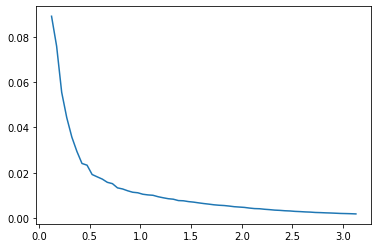

In [13]:
plt.plot(k,pk[0])

In [14]:
bs = 128
def model_pk_iterate(theta):
    halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 
    zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)
    zheng07_model.param_dict['logMmin'] =theta[0] 
    zheng07_model.param_dict['sigma_logM'] =theta[1] 
    zheng07_model.param_dict['logM0'] =theta[2] 
    zheng07_model.param_dict['logM1'] =theta[3] 
    zheng07_model.param_dict['alpha'] =theta[4] 

    zheng07_model.populate_mock(halocat) 
    ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
    filt= np.logical_and(np.logical_and(ht_sample[:,0]<box_size,ht_sample[:,1]<box_size),ht_sample[:,2]<box_size)
    field = cic_paint(tf.zeros((1, bs, bs, bs)),ht_sample[filt].reshape(1,-1,3))

   # data = numpy.empty(ht_sample.shape[0], dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])

   # data['Position'] = ht_sample/250*bs
    #data['Mass'] = np.ones(ht_sample.shape[0])
    #f = ArrayCatalog(data)
    #mesh = f.to_mesh(BoxSize=128,Nmesh=128,window='cic')
    #one_plus_delta = mesh.paint(mode='real')

    return PS.pk_tf(field)#,field[0]


In [15]:
theta_fid = np.array([12.02, 0.26, 11.38, 13.31, 1.06]) # value from https://github.com/DifferentiableUniverseInitiative/DHOD/blob/batch_hmc/nb/batch_hod-hmc-overview.ipynb
theta_off = np.array([13.02, 0.26, 11.38, 13.31, 1.06]) # value from https://github.com/DifferentiableUniverseInitiative/DHOD/blob/batch_hmc/nb/batch_hod-hmc-overview.ipynb


In [16]:
_, _pk_model = model_pk_iterate(theta_fid)


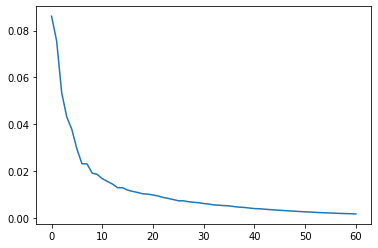

In [17]:
plt.plot(_pk_model[0])

In [18]:
mean = np.load("mean.npy")
cov = np.load("cov_use.npy")

In [19]:
mean.shape

(20,)

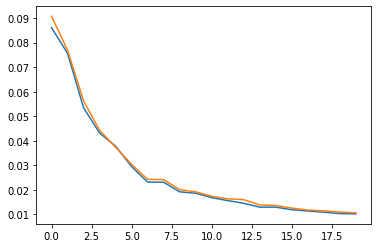

In [20]:
plt.plot(_pk_model[0][:20])
plt.plot(mean)

In [21]:
import tensorflow_probability as tfp 
tfd = tfp.distributions

#noise = 100 # will come from dhod covariance used

klim_2 = k<1.0

prior_loc = [12.00, 0.25, 11.25, 13.20, 1.00]#[12,0.25]
prior_width = [1/2,1/5,1/2,1/2,1/5]
def lnProb(theta): 
    '''log probability
    '''
    print("eval")
    _, _pk_model = model_pk_iterate(theta)
    pk_model = _pk_model[:,:20]
    
    ''' prior'''
    prior = tfp.distributions.MultivariateNormalDiag(loc = prior_loc, scale_diag=prior_width).log_prob(theta)
    print(prior)
    return prior+tfp.distributions.MultivariateNormalFullCovariance(loc=mean,covariance_matrix=cov+ 8.0*10**-5*np.eye(20,20,dtype=np.float32)).log_prob(pk_model)#tfd.MultivariateNormalDiag(loc=mean,scale_diag=diag_std).log_prob(pk)/25

    #chi2 = np.dot(dpk[klim_2],  dpk[klim_2])/noise
    #return -0.5*chi2

In [22]:
theta_fid = np.array([12.02, 0.26,11.25, 13.00, 1.00]) # value from https://github.com/DifferentiableUniverseInitiative/DHOD/blob/batch_hmc/nb/batch_hod-hmc-overview.ipynb
theta_off = np.array([13.02,   0.26,11.25, 13.00, 1.00]) # value from https://github.com/DifferentiableUniverseInitiative/DHOD/blob/batch_hmc/nb/batch_hod-hmc-overview.ipynb


In [23]:
lnProb(theta_fid)

eval
tf.Tensor(0.6215749, shape=(), dtype=float32)
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


2022-10-18 01:11:23.807312: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x558921406760


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([5.890488], dtype=float32)>

In [24]:
lnProb(theta_off)

eval
tf.Tensor(-1.458427, shape=(), dtype=float32)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([45.023415], dtype=float32)>

In [25]:
k_off,pk_off = model_pk_iterate(theta_off)
k_fid,pk_fid = model_pk_iterate(theta_fid)

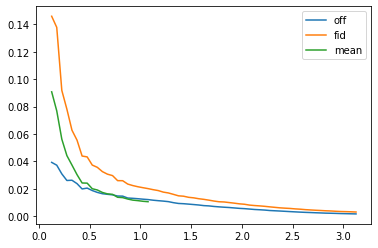

In [26]:
plt.plot(k_off,pk_off[0],label="off")
plt.plot(k_off,pk_fid[0],label="fid")
plt.plot(k_off[:20],mean,label="mean")
plt.legend()


In [28]:

pos = theta_fid[0:5] + 0.5e-1 * np.random.randn(10, 5)
nwalkers, ndim = pos.shape

In [30]:
ndim, nwalkers

(5, 10)

In [ ]:
import time
import emcee
start_time = time.time()
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnProb)
sampler.run_mcmc(pos,1000);
finish_time = time.time()

eval
tf.Tensor(0.5079398, shape=(), dtype=float32)
eval
tf.Tensor(0.46399736, shape=(), dtype=float32)
eval
tf.Tensor(0.66131353, shape=(), dtype=float32)
eval
tf.Tensor(0.5897107, shape=(), dtype=float32)
eval
tf.Tensor(0.5491228, shape=(), dtype=float32)
eval
tf.Tensor(0.6041522, shape=(), dtype=float32)
eval
tf.Tensor(0.56798506, shape=(), dtype=float32)
eval
tf.Tensor(0.59280825, shape=(), dtype=float32)
eval
tf.Tensor(0.5777154, shape=(), dtype=float32)
eval
tf.Tensor(0.58974695, shape=(), dtype=float32)
eval
tf.Tensor(0.6219487, shape=(), dtype=float32)
eval
tf.Tensor(0.605227, shape=(), dtype=float32)
eval
tf.Tensor(0.5875125, shape=(), dtype=float32)
eval
tf.Tensor(0.5990367, shape=(), dtype=float32)
eval
tf.Tensor(0.56746435, shape=(), dtype=float32)
eval
tf.Tensor(0.39344263, shape=(), dtype=float32)
eval
tf.Tensor(0.51430607, shape=(), dtype=float32)
eval
tf.Tensor(0.6540866, shape=(), dtype=float32)
eval
tf.Tensor(0.53643894, shape=(), dtype=float32)
eval
tf.Tensor(0.549423

tf.Tensor(0.5209913, shape=(), dtype=float32)
eval
tf.Tensor(0.53276825, shape=(), dtype=float32)
eval
tf.Tensor(0.26635122, shape=(), dtype=float32)
eval
tf.Tensor(-0.4361143, shape=(), dtype=float32)
eval
tf.Tensor(0.63008785, shape=(), dtype=float32)
eval
tf.Tensor(0.2342186, shape=(), dtype=float32)
eval
tf.Tensor(0.62773705, shape=(), dtype=float32)
eval
tf.Tensor(-0.42442274, shape=(), dtype=float32)
eval
tf.Tensor(0.38765, shape=(), dtype=float32)
eval
tf.Tensor(0.40942717, shape=(), dtype=float32)
eval
tf.Tensor(0.6180291, shape=(), dtype=float32)
eval
tf.Tensor(0.6212249, shape=(), dtype=float32)
eval
tf.Tensor(0.1833005, shape=(), dtype=float32)
eval
tf.Tensor(0.24470758, shape=(), dtype=float32)
eval
tf.Tensor(0.32872248, shape=(), dtype=float32)
eval
tf.Tensor(0.12779665, shape=(), dtype=float32)
eval
tf.Tensor(0.35438776, shape=(), dtype=float32)
eval
tf.Tensor(0.6147857, shape=(), dtype=float32)
eval
tf.Tensor(-2.2578673, shape=(), dtype=float32)
eval
tf.Tensor(-3.2300935

tf.Tensor(0.37369108, shape=(), dtype=float32)
eval
tf.Tensor(0.26881838, shape=(), dtype=float32)
eval
tf.Tensor(0.5705228, shape=(), dtype=float32)
eval
tf.Tensor(0.57355404, shape=(), dtype=float32)
eval
tf.Tensor(-2.1728563, shape=(), dtype=float32)
eval
tf.Tensor(-0.076890945, shape=(), dtype=float32)
eval
tf.Tensor(0.57788706, shape=(), dtype=float32)
eval
tf.Tensor(-0.66841316, shape=(), dtype=float32)
eval
tf.Tensor(0.6091671, shape=(), dtype=float32)
eval
tf.Tensor(0.43084955, shape=(), dtype=float32)
eval
tf.Tensor(0.49617863, shape=(), dtype=float32)
eval
tf.Tensor(-0.5479045, shape=(), dtype=float32)
eval
tf.Tensor(0.41999388, shape=(), dtype=float32)
eval
tf.Tensor(-8.044428, shape=(), dtype=float32)
eval
tf.Tensor(0.13244247, shape=(), dtype=float32)
eval
tf.Tensor(0.36935234, shape=(), dtype=float32)
eval
tf.Tensor(-0.6459446, shape=(), dtype=float32)
eval
tf.Tensor(0.388669, shape=(), dtype=float32)
eval
tf.Tensor(0.5617895, shape=(), dtype=float32)
eval
tf.Tensor(0.633

tf.Tensor(-4.0269084, shape=(), dtype=float32)
eval
tf.Tensor(0.17870378, shape=(), dtype=float32)
eval
tf.Tensor(0.55830526, shape=(), dtype=float32)
eval
tf.Tensor(0.033177853, shape=(), dtype=float32)
eval
tf.Tensor(0.56107473, shape=(), dtype=float32)
eval
tf.Tensor(0.5662298, shape=(), dtype=float32)
eval
tf.Tensor(0.27054882, shape=(), dtype=float32)
eval
tf.Tensor(-1.8319459, shape=(), dtype=float32)
eval
tf.Tensor(0.5819802, shape=(), dtype=float32)
eval
tf.Tensor(-0.7349515, shape=(), dtype=float32)
eval
tf.Tensor(0.44906235, shape=(), dtype=float32)
eval
tf.Tensor(-2.2577672, shape=(), dtype=float32)
eval
tf.Tensor(-2.3024068, shape=(), dtype=float32)
eval
tf.Tensor(0.5926814, shape=(), dtype=float32)
eval
tf.Tensor(-2.0733604, shape=(), dtype=float32)
eval
tf.Tensor(0.04098749, shape=(), dtype=float32)
eval
tf.Tensor(0.24735308, shape=(), dtype=float32)
eval
tf.Tensor(-4.4850364, shape=(), dtype=float32)
eval
tf.Tensor(0.59877396, shape=(), dtype=float32)
eval
tf.Tensor(0.43

tf.Tensor(0.20556068, shape=(), dtype=float32)
eval
tf.Tensor(-0.53571606, shape=(), dtype=float32)
eval
tf.Tensor(-3.3980727, shape=(), dtype=float32)
eval
tf.Tensor(-0.28402853, shape=(), dtype=float32)
eval
tf.Tensor(-1.8885789, shape=(), dtype=float32)
eval
tf.Tensor(-1.935461, shape=(), dtype=float32)
eval
tf.Tensor(-0.15027189, shape=(), dtype=float32)
eval
tf.Tensor(-1.8876176, shape=(), dtype=float32)
eval
tf.Tensor(-3.3033748, shape=(), dtype=float32)
eval
tf.Tensor(-12.993189, shape=(), dtype=float32)
eval
tf.Tensor(-0.34135246, shape=(), dtype=float32)
eval
tf.Tensor(0.05276394, shape=(), dtype=float32)
eval
tf.Tensor(-1.2151647, shape=(), dtype=float32)
eval
tf.Tensor(-0.17819548, shape=(), dtype=float32)
eval
tf.Tensor(-0.35086298, shape=(), dtype=float32)
eval
tf.Tensor(0.60451937, shape=(), dtype=float32)
eval
tf.Tensor(-1.9811559, shape=(), dtype=float32)
eval
tf.Tensor(-0.1620059, shape=(), dtype=float32)
eval
tf.Tensor(-2.5736918, shape=(), dtype=float32)
eval
tf.Tens

tf.Tensor(-5.9639907, shape=(), dtype=float32)
eval
tf.Tensor(-1.7898774, shape=(), dtype=float32)
eval
tf.Tensor(-1.8561435, shape=(), dtype=float32)
eval
tf.Tensor(0.091080666, shape=(), dtype=float32)
eval
tf.Tensor(-0.10987902, shape=(), dtype=float32)
eval
tf.Tensor(-0.08780241, shape=(), dtype=float32)
eval
tf.Tensor(-0.506021, shape=(), dtype=float32)
eval
tf.Tensor(-4.165317, shape=(), dtype=float32)
eval
tf.Tensor(-0.5951028, shape=(), dtype=float32)
eval
tf.Tensor(-0.126369, shape=(), dtype=float32)
eval
tf.Tensor(-0.12925005, shape=(), dtype=float32)
eval
tf.Tensor(0.091328144, shape=(), dtype=float32)
eval
tf.Tensor(-0.5706625, shape=(), dtype=float32)
eval
tf.Tensor(-3.8604102, shape=(), dtype=float32)
eval
tf.Tensor(-7.0941234, shape=(), dtype=float32)
eval
tf.Tensor(0.6312194, shape=(), dtype=float32)
eval
tf.Tensor(-0.54846334, shape=(), dtype=float32)
eval
tf.Tensor(0.3474517, shape=(), dtype=float32)
eval
tf.Tensor(-0.8466172, shape=(), dtype=float32)
eval
tf.Tensor(0

tf.Tensor(0.61493254, shape=(), dtype=float32)
eval
tf.Tensor(-0.51294947, shape=(), dtype=float32)
eval
tf.Tensor(-1.8496237, shape=(), dtype=float32)
eval
tf.Tensor(-3.3216147, shape=(), dtype=float32)
eval
tf.Tensor(-3.308065, shape=(), dtype=float32)
eval
tf.Tensor(-1.3663068, shape=(), dtype=float32)
eval
tf.Tensor(0.007812023, shape=(), dtype=float32)
eval
tf.Tensor(-0.54252386, shape=(), dtype=float32)
eval
tf.Tensor(-4.010899, shape=(), dtype=float32)
eval
tf.Tensor(-0.82033014, shape=(), dtype=float32)
eval
tf.Tensor(-0.81405497, shape=(), dtype=float32)
eval
tf.Tensor(-0.6314664, shape=(), dtype=float32)
eval
tf.Tensor(-1.0587754, shape=(), dtype=float32)
eval
tf.Tensor(-5.1023974, shape=(), dtype=float32)
eval
tf.Tensor(0.43268728, shape=(), dtype=float32)
eval
tf.Tensor(-0.7948184, shape=(), dtype=float32)
eval
tf.Tensor(-0.16946316, shape=(), dtype=float32)
eval
tf.Tensor(-8.468754, shape=(), dtype=float32)
eval
tf.Tensor(-15.240002, shape=(), dtype=float32)
eval
tf.Tensor

tf.Tensor(-1.7220368, shape=(), dtype=float32)
eval
tf.Tensor(-6.726006, shape=(), dtype=float32)
eval
tf.Tensor(-4.6187024, shape=(), dtype=float32)
eval
tf.Tensor(-5.577432, shape=(), dtype=float32)
eval
tf.Tensor(-7.6619163, shape=(), dtype=float32)
eval
tf.Tensor(-2.5525842, shape=(), dtype=float32)
eval
tf.Tensor(-1.396966, shape=(), dtype=float32)
eval
tf.Tensor(-1.2013955, shape=(), dtype=float32)
eval
tf.Tensor(-0.120764256, shape=(), dtype=float32)
eval
tf.Tensor(-1.3846416, shape=(), dtype=float32)
eval
tf.Tensor(-2.0869393, shape=(), dtype=float32)
eval
tf.Tensor(-0.8342376, shape=(), dtype=float32)
eval
tf.Tensor(-1.7193837, shape=(), dtype=float32)
eval
tf.Tensor(-0.92541075, shape=(), dtype=float32)
eval
tf.Tensor(-1.1280885, shape=(), dtype=float32)
eval
tf.Tensor(-2.158173, shape=(), dtype=float32)
eval
tf.Tensor(-3.4379115, shape=(), dtype=float32)
eval
tf.Tensor(0.35817146, shape=(), dtype=float32)
eval
tf.Tensor(-2.1836514, shape=(), dtype=float32)
eval
tf.Tensor(-11

tf.Tensor(-3.3485084, shape=(), dtype=float32)
eval
tf.Tensor(-5.2216525, shape=(), dtype=float32)
eval
tf.Tensor(-3.79143, shape=(), dtype=float32)
eval
tf.Tensor(-1.3306675, shape=(), dtype=float32)
eval
tf.Tensor(-0.054931164, shape=(), dtype=float32)
eval
tf.Tensor(-1.2778387, shape=(), dtype=float32)
eval
tf.Tensor(-0.8195605, shape=(), dtype=float32)
eval
tf.Tensor(-1.0811219, shape=(), dtype=float32)
eval
tf.Tensor(-0.64341307, shape=(), dtype=float32)
eval
tf.Tensor(-0.84919596, shape=(), dtype=float32)
eval
tf.Tensor(-2.4547458, shape=(), dtype=float32)
eval
tf.Tensor(-4.3661246, shape=(), dtype=float32)
eval
tf.Tensor(-5.0477624, shape=(), dtype=float32)
eval
tf.Tensor(-0.3345647, shape=(), dtype=float32)
eval
tf.Tensor(-1.6670432, shape=(), dtype=float32)
eval
tf.Tensor(0.018640041, shape=(), dtype=float32)
eval
tf.Tensor(-3.5003486, shape=(), dtype=float32)
eval
tf.Tensor(-0.5541086, shape=(), dtype=float32)
eval
tf.Tensor(-4.2644477, shape=(), dtype=float32)
eval
tf.Tensor

tf.Tensor(-0.47680664, shape=(), dtype=float32)
eval
tf.Tensor(-1.2971034, shape=(), dtype=float32)
eval
tf.Tensor(-1.740767, shape=(), dtype=float32)
eval
tf.Tensor(0.39533567, shape=(), dtype=float32)
eval
tf.Tensor(0.25235224, shape=(), dtype=float32)
eval
tf.Tensor(-6.3766932, shape=(), dtype=float32)
eval
tf.Tensor(-1.6822639, shape=(), dtype=float32)
eval
tf.Tensor(-3.249601, shape=(), dtype=float32)
eval
tf.Tensor(0.3892913, shape=(), dtype=float32)
eval
tf.Tensor(0.49895906, shape=(), dtype=float32)
eval
tf.Tensor(-2.1374884, shape=(), dtype=float32)
eval
tf.Tensor(-3.236135, shape=(), dtype=float32)
eval
tf.Tensor(-1.6497974, shape=(), dtype=float32)
eval
tf.Tensor(0.52266884, shape=(), dtype=float32)
eval
tf.Tensor(-2.1554003, shape=(), dtype=float32)
eval
tf.Tensor(-0.3624425, shape=(), dtype=float32)
eval
tf.Tensor(-12.623791, shape=(), dtype=float32)
eval
tf.Tensor(-1.0234017, shape=(), dtype=float32)
eval
tf.Tensor(-2.3178601, shape=(), dtype=float32)
eval
tf.Tensor(0.324

tf.Tensor(-0.37113142, shape=(), dtype=float32)
eval
tf.Tensor(-1.2504311, shape=(), dtype=float32)
eval
tf.Tensor(-5.1413817, shape=(), dtype=float32)
eval
tf.Tensor(-0.10328579, shape=(), dtype=float32)
eval
tf.Tensor(-0.04584837, shape=(), dtype=float32)
eval
tf.Tensor(-4.896361, shape=(), dtype=float32)
eval
tf.Tensor(-3.4447637, shape=(), dtype=float32)
eval
tf.Tensor(-1.5520005, shape=(), dtype=float32)
eval
tf.Tensor(0.5646386, shape=(), dtype=float32)
eval
tf.Tensor(0.35096216, shape=(), dtype=float32)
eval
tf.Tensor(-4.7750573, shape=(), dtype=float32)
eval
tf.Tensor(-0.49352884, shape=(), dtype=float32)
eval
tf.Tensor(-3.577251, shape=(), dtype=float32)
eval
tf.Tensor(0.06971502, shape=(), dtype=float32)
eval
tf.Tensor(-7.0828586, shape=(), dtype=float32)
eval
tf.Tensor(-4.757626, shape=(), dtype=float32)
eval
tf.Tensor(-1.1447182, shape=(), dtype=float32)
eval
tf.Tensor(-1.2787738, shape=(), dtype=float32)
eval
tf.Tensor(-0.2437725, shape=(), dtype=float32)
eval
tf.Tensor(-0

tf.Tensor(-0.33473158, shape=(), dtype=float32)
eval
tf.Tensor(-3.2688375, shape=(), dtype=float32)
eval
tf.Tensor(-0.02521658, shape=(), dtype=float32)
eval
tf.Tensor(-0.35340834, shape=(), dtype=float32)
eval
tf.Tensor(-2.415485, shape=(), dtype=float32)
eval
tf.Tensor(-3.583631, shape=(), dtype=float32)
eval
tf.Tensor(0.16695166, shape=(), dtype=float32)
eval
tf.Tensor(-1.5829544, shape=(), dtype=float32)
eval
tf.Tensor(0.20072746, shape=(), dtype=float32)
eval
tf.Tensor(-0.4056635, shape=(), dtype=float32)
eval
tf.Tensor(-11.037506, shape=(), dtype=float32)
eval
tf.Tensor(-8.320276, shape=(), dtype=float32)
eval
tf.Tensor(-3.4241862, shape=(), dtype=float32)
eval
tf.Tensor(0.29499722, shape=(), dtype=float32)
eval
tf.Tensor(-0.21464682, shape=(), dtype=float32)
eval
tf.Tensor(-1.4750805, shape=(), dtype=float32)
eval
tf.Tensor(0.25755548, shape=(), dtype=float32)
eval
tf.Tensor(0.25102758, shape=(), dtype=float32)
eval
tf.Tensor(0.65054274, shape=(), dtype=float32)
eval
tf.Tensor(-

tf.Tensor(-1.2223897, shape=(), dtype=float32)
eval
tf.Tensor(-1.5025501, shape=(), dtype=float32)
eval
tf.Tensor(-1.7876692, shape=(), dtype=float32)
eval
tf.Tensor(-11.5052185, shape=(), dtype=float32)
eval
tf.Tensor(-14.068573, shape=(), dtype=float32)
eval
tf.Tensor(-2.5500174, shape=(), dtype=float32)
eval
tf.Tensor(-2.3531203, shape=(), dtype=float32)
eval
tf.Tensor(-3.2371879, shape=(), dtype=float32)
eval
tf.Tensor(-6.4703183, shape=(), dtype=float32)
eval
tf.Tensor(-2.619244, shape=(), dtype=float32)
eval
tf.Tensor(-3.053203, shape=(), dtype=float32)
eval
tf.Tensor(-0.84049463, shape=(), dtype=float32)
eval
tf.Tensor(-5.5878844, shape=(), dtype=float32)
eval
tf.Tensor(-2.0321412, shape=(), dtype=float32)
eval
tf.Tensor(-0.80882597, shape=(), dtype=float32)
eval
tf.Tensor(-2.5267396, shape=(), dtype=float32)
eval
tf.Tensor(-7.344705, shape=(), dtype=float32)
eval
tf.Tensor(-7.622045, shape=(), dtype=float32)
eval
tf.Tensor(-5.725882, shape=(), dtype=float32)
eval
tf.Tensor(-10.

tf.Tensor(-1.0782723, shape=(), dtype=float32)
eval
tf.Tensor(-1.9526281, shape=(), dtype=float32)
eval
tf.Tensor(0.040137768, shape=(), dtype=float32)
eval
tf.Tensor(-5.837068, shape=(), dtype=float32)
eval
tf.Tensor(-0.9459119, shape=(), dtype=float32)
eval
tf.Tensor(-2.2282891, shape=(), dtype=float32)
eval
tf.Tensor(-8.60931, shape=(), dtype=float32)
eval
tf.Tensor(-4.829065, shape=(), dtype=float32)
eval
tf.Tensor(-1.2990241, shape=(), dtype=float32)
eval
tf.Tensor(0.45737648, shape=(), dtype=float32)
eval
tf.Tensor(-0.27678108, shape=(), dtype=float32)
eval
tf.Tensor(0.40850973, shape=(), dtype=float32)
eval
tf.Tensor(-0.5135517, shape=(), dtype=float32)
eval
tf.Tensor(-4.183967, shape=(), dtype=float32)
eval
tf.Tensor(0.45161533, shape=(), dtype=float32)
eval
tf.Tensor(-2.7345176, shape=(), dtype=float32)
eval
tf.Tensor(-0.3373828, shape=(), dtype=float32)
eval
tf.Tensor(-0.7615123, shape=(), dtype=float32)
eval
tf.Tensor(-0.694355, shape=(), dtype=float32)
eval
tf.Tensor(-7.428

tf.Tensor(-1.0799317, shape=(), dtype=float32)
eval
tf.Tensor(-0.0050201416, shape=(), dtype=float32)
eval
tf.Tensor(-0.21278143, shape=(), dtype=float32)
eval
tf.Tensor(0.37228537, shape=(), dtype=float32)
eval
tf.Tensor(-5.936669, shape=(), dtype=float32)
eval
tf.Tensor(-0.29802084, shape=(), dtype=float32)
eval
tf.Tensor(-1.4701443, shape=(), dtype=float32)
eval
tf.Tensor(-1.1612825, shape=(), dtype=float32)
eval
tf.Tensor(-1.4205861, shape=(), dtype=float32)
eval
tf.Tensor(-3.9994655, shape=(), dtype=float32)
eval
tf.Tensor(-3.3408237, shape=(), dtype=float32)
eval
tf.Tensor(-0.22643375, shape=(), dtype=float32)
eval
tf.Tensor(0.5460706, shape=(), dtype=float32)
eval
tf.Tensor(-2.4207392, shape=(), dtype=float32)
eval
tf.Tensor(0.02098322, shape=(), dtype=float32)
eval
tf.Tensor(-0.32605553, shape=(), dtype=float32)
eval
tf.Tensor(0.16081572, shape=(), dtype=float32)
eval
tf.Tensor(-0.83650064, shape=(), dtype=float32)
eval
tf.Tensor(-7.043734, shape=(), dtype=float32)
eval
tf.Tens

tf.Tensor(-3.4707694, shape=(), dtype=float32)
eval
tf.Tensor(0.19522476, shape=(), dtype=float32)
eval
tf.Tensor(-2.2476525, shape=(), dtype=float32)
eval
tf.Tensor(-13.442631, shape=(), dtype=float32)
eval
tf.Tensor(-1.4454665, shape=(), dtype=float32)
eval
tf.Tensor(-0.28666353, shape=(), dtype=float32)
eval
tf.Tensor(-1.5099716, shape=(), dtype=float32)
eval
tf.Tensor(-6.2925506, shape=(), dtype=float32)
eval
tf.Tensor(-2.9111161, shape=(), dtype=float32)
eval
tf.Tensor(-2.0604172, shape=(), dtype=float32)
eval
tf.Tensor(-5.432487, shape=(), dtype=float32)
eval
tf.Tensor(0.64834595, shape=(), dtype=float32)
eval
tf.Tensor(-0.91760063, shape=(), dtype=float32)
eval
tf.Tensor(-2.5505557, shape=(), dtype=float32)
eval
tf.Tensor(-8.766111, shape=(), dtype=float32)
eval
tf.Tensor(-2.5090194, shape=(), dtype=float32)
eval
tf.Tensor(-0.46926975, shape=(), dtype=float32)
eval
tf.Tensor(-2.2518425, shape=(), dtype=float32)
eval
tf.Tensor(-2.7398849, shape=(), dtype=float32)
eval
tf.Tensor(-

tf.Tensor(0.07507658, shape=(), dtype=float32)
eval
tf.Tensor(-3.3537621, shape=(), dtype=float32)
eval
tf.Tensor(0.03298235, shape=(), dtype=float32)
eval
tf.Tensor(-0.25738573, shape=(), dtype=float32)
eval
tf.Tensor(0.2064085, shape=(), dtype=float32)
eval
tf.Tensor(0.3810072, shape=(), dtype=float32)
eval
tf.Tensor(-0.9529033, shape=(), dtype=float32)
eval
tf.Tensor(-4.4537787, shape=(), dtype=float32)
eval
tf.Tensor(-6.1749225, shape=(), dtype=float32)
eval
tf.Tensor(-4.405395, shape=(), dtype=float32)
eval
tf.Tensor(0.2147932, shape=(), dtype=float32)
eval
tf.Tensor(-3.464395, shape=(), dtype=float32)
eval
tf.Tensor(-4.4675364, shape=(), dtype=float32)
eval
tf.Tensor(-2.5050125, shape=(), dtype=float32)
eval
tf.Tensor(-0.9391322, shape=(), dtype=float32)
eval
tf.Tensor(-0.44836235, shape=(), dtype=float32)
eval
tf.Tensor(-1.2819977, shape=(), dtype=float32)
eval
tf.Tensor(0.1897378, shape=(), dtype=float32)
eval
tf.Tensor(-14.074024, shape=(), dtype=float32)
eval
tf.Tensor(0.1170

tf.Tensor(-1.4011436, shape=(), dtype=float32)
eval
tf.Tensor(0.013160229, shape=(), dtype=float32)
eval
tf.Tensor(0.39538097, shape=(), dtype=float32)
eval
tf.Tensor(-1.2428489, shape=(), dtype=float32)
eval
tf.Tensor(-1.788249, shape=(), dtype=float32)
eval
tf.Tensor(-1.5128016, shape=(), dtype=float32)
eval
tf.Tensor(0.3658619, shape=(), dtype=float32)
eval
tf.Tensor(-6.3108373, shape=(), dtype=float32)
eval
tf.Tensor(-0.29897642, shape=(), dtype=float32)
eval
tf.Tensor(-12.918953, shape=(), dtype=float32)
eval
tf.Tensor(-2.222167, shape=(), dtype=float32)
eval
tf.Tensor(-3.2809558, shape=(), dtype=float32)
eval
tf.Tensor(-0.3524413, shape=(), dtype=float32)
eval
tf.Tensor(-0.10829735, shape=(), dtype=float32)
eval
tf.Tensor(-0.90204, shape=(), dtype=float32)
eval
tf.Tensor(-2.0016665, shape=(), dtype=float32)
eval
tf.Tensor(0.3988676, shape=(), dtype=float32)
eval
tf.Tensor(0.1926136, shape=(), dtype=float32)
eval
tf.Tensor(-1.3344407, shape=(), dtype=float32)
eval
tf.Tensor(-0.780

tf.Tensor(-1.270688, shape=(), dtype=float32)
eval
tf.Tensor(-0.7530241, shape=(), dtype=float32)
eval
tf.Tensor(0.35954046, shape=(), dtype=float32)
eval
tf.Tensor(-1.550097, shape=(), dtype=float32)
eval
tf.Tensor(-2.565289, shape=(), dtype=float32)
eval
tf.Tensor(-2.7184224, shape=(), dtype=float32)
eval
tf.Tensor(-5.290199, shape=(), dtype=float32)
eval
tf.Tensor(0.34187365, shape=(), dtype=float32)
eval
tf.Tensor(0.51069355, shape=(), dtype=float32)
eval
tf.Tensor(-0.13918018, shape=(), dtype=float32)
eval
tf.Tensor(0.29832745, shape=(), dtype=float32)
eval
tf.Tensor(-1.3998346, shape=(), dtype=float32)
eval
tf.Tensor(-0.73346186, shape=(), dtype=float32)
eval
tf.Tensor(0.48203802, shape=(), dtype=float32)
eval
tf.Tensor(-0.3563161, shape=(), dtype=float32)
eval
tf.Tensor(0.38475227, shape=(), dtype=float32)
eval
tf.Tensor(-4.7646422, shape=(), dtype=float32)
eval
tf.Tensor(-1.1379046, shape=(), dtype=float32)
eval
tf.Tensor(-0.08295679, shape=(), dtype=float32)
eval
tf.Tensor(-0.

tf.Tensor(0.49002504, shape=(), dtype=float32)
eval
tf.Tensor(-0.59324026, shape=(), dtype=float32)
eval
tf.Tensor(-0.449821, shape=(), dtype=float32)
eval
tf.Tensor(-0.05836916, shape=(), dtype=float32)
eval
tf.Tensor(-1.563725, shape=(), dtype=float32)
eval
tf.Tensor(0.021450996, shape=(), dtype=float32)
eval
tf.Tensor(-0.64819956, shape=(), dtype=float32)
eval
tf.Tensor(-2.5634465, shape=(), dtype=float32)
eval
tf.Tensor(-2.0465894, shape=(), dtype=float32)
eval
tf.Tensor(0.071498394, shape=(), dtype=float32)
eval
tf.Tensor(-3.2009912, shape=(), dtype=float32)
eval
tf.Tensor(-0.081100464, shape=(), dtype=float32)
eval
tf.Tensor(-0.48890543, shape=(), dtype=float32)
eval
tf.Tensor(0.40925837, shape=(), dtype=float32)
eval
tf.Tensor(0.080767155, shape=(), dtype=float32)
eval
tf.Tensor(0.5348029, shape=(), dtype=float32)
eval
tf.Tensor(-0.33009768, shape=(), dtype=float32)
eval
tf.Tensor(-4.9194245, shape=(), dtype=float32)
eval
tf.Tensor(0.069242, shape=(), dtype=float32)
eval
tf.Tens

tf.Tensor(-14.375347, shape=(), dtype=float32)
eval
tf.Tensor(-2.0844197, shape=(), dtype=float32)
eval
tf.Tensor(0.59163666, shape=(), dtype=float32)
eval
tf.Tensor(-2.2487788, shape=(), dtype=float32)
eval
tf.Tensor(-5.4054284, shape=(), dtype=float32)
eval
tf.Tensor(-0.07237482, shape=(), dtype=float32)
eval
tf.Tensor(-1.9685931, shape=(), dtype=float32)
eval
tf.Tensor(-4.226134, shape=(), dtype=float32)
eval
tf.Tensor(-1.5494447, shape=(), dtype=float32)
eval
tf.Tensor(-5.4403253, shape=(), dtype=float32)
eval
tf.Tensor(-1.5658484, shape=(), dtype=float32)
eval
tf.Tensor(-4.601382, shape=(), dtype=float32)
eval
tf.Tensor(0.4669366, shape=(), dtype=float32)
eval
tf.Tensor(-1.1936164, shape=(), dtype=float32)
eval
tf.Tensor(-0.4159541, shape=(), dtype=float32)
eval
tf.Tensor(-1.1414385, shape=(), dtype=float32)
eval
tf.Tensor(-0.97452974, shape=(), dtype=float32)
eval
tf.Tensor(-3.485355, shape=(), dtype=float32)
eval
tf.Tensor(-4.439917, shape=(), dtype=float32)
eval
tf.Tensor(-3.55

tf.Tensor(-1.8360429, shape=(), dtype=float32)
eval
tf.Tensor(-3.0208821, shape=(), dtype=float32)
eval
tf.Tensor(-0.9855447, shape=(), dtype=float32)
eval
tf.Tensor(-12.814297, shape=(), dtype=float32)
eval
tf.Tensor(0.21755552, shape=(), dtype=float32)
eval
tf.Tensor(-14.114117, shape=(), dtype=float32)
eval
tf.Tensor(-0.3488598, shape=(), dtype=float32)
eval
tf.Tensor(-0.40578318, shape=(), dtype=float32)
eval
tf.Tensor(-6.185159, shape=(), dtype=float32)
eval
tf.Tensor(-4.8195195, shape=(), dtype=float32)
eval
tf.Tensor(-0.5112171, shape=(), dtype=float32)
eval
tf.Tensor(-6.846638, shape=(), dtype=float32)
eval
tf.Tensor(-2.1547694, shape=(), dtype=float32)
eval
tf.Tensor(-0.1866312, shape=(), dtype=float32)
eval
tf.Tensor(-7.550444, shape=(), dtype=float32)
eval
tf.Tensor(-4.1247325, shape=(), dtype=float32)
eval
tf.Tensor(-1.4211955, shape=(), dtype=float32)
eval
tf.Tensor(-6.131905, shape=(), dtype=float32)
eval
tf.Tensor(-0.12060261, shape=(), dtype=float32)
eval
tf.Tensor(-0.5

tf.Tensor(-0.34616804, shape=(), dtype=float32)
eval
tf.Tensor(-16.725506, shape=(), dtype=float32)
eval
tf.Tensor(-0.90764284, shape=(), dtype=float32)
eval
tf.Tensor(-0.23252153, shape=(), dtype=float32)
eval
tf.Tensor(-0.20417118, shape=(), dtype=float32)
eval
tf.Tensor(-17.472786, shape=(), dtype=float32)
eval
tf.Tensor(-9.629816, shape=(), dtype=float32)
eval
tf.Tensor(-0.99500895, shape=(), dtype=float32)
eval
tf.Tensor(0.24822092, shape=(), dtype=float32)
eval
tf.Tensor(-0.27197123, shape=(), dtype=float32)
eval
tf.Tensor(-0.5747204, shape=(), dtype=float32)
eval
tf.Tensor(-8.138168, shape=(), dtype=float32)
eval
tf.Tensor(-0.14209175, shape=(), dtype=float32)
eval
tf.Tensor(-10.758608, shape=(), dtype=float32)
eval
tf.Tensor(-1.6405182, shape=(), dtype=float32)
eval
tf.Tensor(0.0880456, shape=(), dtype=float32)
eval
tf.Tensor(-11.156862, shape=(), dtype=float32)
eval
tf.Tensor(-3.658051, shape=(), dtype=float32)
eval
tf.Tensor(-1.1395869, shape=(), dtype=float32)
eval
tf.Tensor

tf.Tensor(0.024439812, shape=(), dtype=float32)
eval
tf.Tensor(-3.5479808, shape=(), dtype=float32)
eval
tf.Tensor(0.12252045, shape=(), dtype=float32)
eval
tf.Tensor(-0.3974743, shape=(), dtype=float32)
eval
tf.Tensor(-0.9702349, shape=(), dtype=float32)
eval
tf.Tensor(-2.5201359, shape=(), dtype=float32)
eval
tf.Tensor(-2.9803958, shape=(), dtype=float32)
eval
tf.Tensor(0.4159217, shape=(), dtype=float32)
eval
tf.Tensor(-5.4134345, shape=(), dtype=float32)
eval
tf.Tensor(0.19499445, shape=(), dtype=float32)
eval
tf.Tensor(-1.9247069, shape=(), dtype=float32)
eval
tf.Tensor(-2.8208842, shape=(), dtype=float32)
eval
tf.Tensor(0.3129115, shape=(), dtype=float32)
eval
tf.Tensor(0.22226, shape=(), dtype=float32)
eval
tf.Tensor(0.18146896, shape=(), dtype=float32)
eval
tf.Tensor(-2.0919547, shape=(), dtype=float32)
eval
tf.Tensor(-0.663857, shape=(), dtype=float32)
eval
tf.Tensor(-1.0337214, shape=(), dtype=float32)
eval
tf.Tensor(-1.8181744, shape=(), dtype=float32)
eval
tf.Tensor(-2.7212

tf.Tensor(0.028158665, shape=(), dtype=float32)
eval
tf.Tensor(-1.0805783, shape=(), dtype=float32)
eval
tf.Tensor(0.28920412, shape=(), dtype=float32)
eval
tf.Tensor(-0.50423336, shape=(), dtype=float32)
eval
tf.Tensor(0.48687983, shape=(), dtype=float32)
eval
tf.Tensor(-5.2246413, shape=(), dtype=float32)
eval
tf.Tensor(0.13935041, shape=(), dtype=float32)
eval
tf.Tensor(-0.088493824, shape=(), dtype=float32)
eval
tf.Tensor(-0.24568987, shape=(), dtype=float32)
eval
tf.Tensor(0.516459, shape=(), dtype=float32)
eval
tf.Tensor(-4.7878413, shape=(), dtype=float32)
eval
tf.Tensor(-0.15903902, shape=(), dtype=float32)
eval
tf.Tensor(-3.3724093, shape=(), dtype=float32)
eval
tf.Tensor(-1.8880057, shape=(), dtype=float32)
eval
tf.Tensor(0.14402866, shape=(), dtype=float32)
eval
tf.Tensor(-0.024065018, shape=(), dtype=float32)
eval
tf.Tensor(-6.784741, shape=(), dtype=float32)
eval
tf.Tensor(-1.4823508, shape=(), dtype=float32)
eval
tf.Tensor(-3.9457126, shape=(), dtype=float32)
eval
tf.Tens

tf.Tensor(-1.2699537, shape=(), dtype=float32)
eval
tf.Tensor(-0.17310524, shape=(), dtype=float32)
eval
tf.Tensor(-8.290644, shape=(), dtype=float32)
eval
tf.Tensor(-0.051790237, shape=(), dtype=float32)
eval
tf.Tensor(-3.0524678, shape=(), dtype=float32)
eval
tf.Tensor(-1.4492979, shape=(), dtype=float32)
eval
tf.Tensor(-2.2224493, shape=(), dtype=float32)
eval
tf.Tensor(-1.3347955, shape=(), dtype=float32)
eval
tf.Tensor(-0.09074545, shape=(), dtype=float32)
eval
tf.Tensor(-2.775145, shape=(), dtype=float32)
eval
tf.Tensor(-0.47920895, shape=(), dtype=float32)
eval
tf.Tensor(-1.1033897, shape=(), dtype=float32)
eval
tf.Tensor(0.23817301, shape=(), dtype=float32)
eval
tf.Tensor(0.25792503, shape=(), dtype=float32)
eval
tf.Tensor(-0.26355124, shape=(), dtype=float32)
eval
tf.Tensor(-1.0209441, shape=(), dtype=float32)
eval
tf.Tensor(-0.20083618, shape=(), dtype=float32)
eval
tf.Tensor(-0.11590433, shape=(), dtype=float32)
eval
tf.Tensor(0.34000778, shape=(), dtype=float32)
eval
tf.Ten

tf.Tensor(-1.2348762, shape=(), dtype=float32)
eval
tf.Tensor(-0.9795065, shape=(), dtype=float32)
eval
tf.Tensor(-4.652127, shape=(), dtype=float32)
eval
tf.Tensor(-0.52790546, shape=(), dtype=float32)
eval
tf.Tensor(0.245327, shape=(), dtype=float32)
eval
tf.Tensor(0.36116076, shape=(), dtype=float32)
eval
tf.Tensor(-6.5722556, shape=(), dtype=float32)
eval
tf.Tensor(-1.4449592, shape=(), dtype=float32)
eval
tf.Tensor(0.4428048, shape=(), dtype=float32)
eval
tf.Tensor(-1.5044475, shape=(), dtype=float32)
eval
tf.Tensor(-3.0427308, shape=(), dtype=float32)
eval
tf.Tensor(-4.5961556, shape=(), dtype=float32)
eval
tf.Tensor(-1.4895773, shape=(), dtype=float32)
eval
tf.Tensor(-5.1815124, shape=(), dtype=float32)
eval
tf.Tensor(0.3547573, shape=(), dtype=float32)
eval
tf.Tensor(0.44176817, shape=(), dtype=float32)
eval
tf.Tensor(-2.1097655, shape=(), dtype=float32)
eval
tf.Tensor(-0.13058996, shape=(), dtype=float32)
eval
tf.Tensor(-4.474466, shape=(), dtype=float32)
eval
tf.Tensor(0.3558

tf.Tensor(-1.6821694, shape=(), dtype=float32)
eval
tf.Tensor(0.1692462, shape=(), dtype=float32)
eval
tf.Tensor(0.3345294, shape=(), dtype=float32)
eval
tf.Tensor(-0.51983786, shape=(), dtype=float32)
eval
tf.Tensor(-1.4945688, shape=(), dtype=float32)
eval
tf.Tensor(-7.6020865, shape=(), dtype=float32)
eval
tf.Tensor(0.26662302, shape=(), dtype=float32)
eval
tf.Tensor(-0.7700858, shape=(), dtype=float32)
eval
tf.Tensor(-6.7131686, shape=(), dtype=float32)
eval
tf.Tensor(-0.6284299, shape=(), dtype=float32)
eval
tf.Tensor(-1.6412005, shape=(), dtype=float32)
eval
tf.Tensor(-4.807033, shape=(), dtype=float32)
eval
tf.Tensor(-3.8137908, shape=(), dtype=float32)
eval
tf.Tensor(0.34233427, shape=(), dtype=float32)
eval
tf.Tensor(0.1876607, shape=(), dtype=float32)
eval
tf.Tensor(-0.85982084, shape=(), dtype=float32)
eval
tf.Tensor(0.11105585, shape=(), dtype=float32)
eval
tf.Tensor(-0.9747348, shape=(), dtype=float32)
eval
tf.Tensor(0.5224285, shape=(), dtype=float32)
eval
tf.Tensor(-3.40

tf.Tensor(-0.5881696, shape=(), dtype=float32)
eval
tf.Tensor(-3.183929, shape=(), dtype=float32)
eval
tf.Tensor(0.46674538, shape=(), dtype=float32)
eval
tf.Tensor(-2.6808877, shape=(), dtype=float32)
eval
tf.Tensor(-2.951551, shape=(), dtype=float32)
eval
tf.Tensor(-1.1371531, shape=(), dtype=float32)
eval
tf.Tensor(-1.5577264, shape=(), dtype=float32)
eval
tf.Tensor(-6.267717, shape=(), dtype=float32)
eval
tf.Tensor(-10.322361, shape=(), dtype=float32)
eval
tf.Tensor(-4.7604737, shape=(), dtype=float32)
eval
tf.Tensor(0.6223445, shape=(), dtype=float32)
eval
tf.Tensor(-11.345217, shape=(), dtype=float32)
eval
tf.Tensor(0.30602217, shape=(), dtype=float32)
eval
tf.Tensor(-0.9034672, shape=(), dtype=float32)
eval
tf.Tensor(-6.243295, shape=(), dtype=float32)
eval
tf.Tensor(-3.9556499, shape=(), dtype=float32)
eval
tf.Tensor(-0.13004637, shape=(), dtype=float32)
eval
tf.Tensor(-15.448002, shape=(), dtype=float32)
eval
tf.Tensor(0.4656558, shape=(), dtype=float32)
eval
tf.Tensor(-0.5472

tf.Tensor(-0.3321395, shape=(), dtype=float32)
eval
tf.Tensor(0.47409964, shape=(), dtype=float32)
eval
tf.Tensor(-0.41645288, shape=(), dtype=float32)
eval
tf.Tensor(-1.2046361, shape=(), dtype=float32)
eval
tf.Tensor(-1.2181525, shape=(), dtype=float32)
eval
tf.Tensor(-3.8228202, shape=(), dtype=float32)
eval
tf.Tensor(-0.39454842, shape=(), dtype=float32)
eval
tf.Tensor(-1.3903232, shape=(), dtype=float32)
eval
tf.Tensor(0.40874577, shape=(), dtype=float32)
eval
tf.Tensor(-0.064236164, shape=(), dtype=float32)
eval
tf.Tensor(-4.6510844, shape=(), dtype=float32)
eval
tf.Tensor(0.42615652, shape=(), dtype=float32)
eval
tf.Tensor(-2.9010072, shape=(), dtype=float32)
eval
tf.Tensor(0.040566444, shape=(), dtype=float32)
eval
tf.Tensor(0.11034441, shape=(), dtype=float32)
eval
tf.Tensor(-3.4166694, shape=(), dtype=float32)
eval
tf.Tensor(0.22817087, shape=(), dtype=float32)
eval
tf.Tensor(-1.8310857, shape=(), dtype=float32)
eval
tf.Tensor(-1.6105065, shape=(), dtype=float32)
eval
tf.Tens

tf.Tensor(-3.119203, shape=(), dtype=float32)
eval
tf.Tensor(-0.048190117, shape=(), dtype=float32)
eval
tf.Tensor(-0.34076452, shape=(), dtype=float32)
eval
tf.Tensor(-2.8976836, shape=(), dtype=float32)
eval
tf.Tensor(-0.30245352, shape=(), dtype=float32)
eval
tf.Tensor(-0.26652288, shape=(), dtype=float32)
eval
tf.Tensor(0.49060106, shape=(), dtype=float32)
eval
tf.Tensor(-0.2911048, shape=(), dtype=float32)
eval
tf.Tensor(-1.2285733, shape=(), dtype=float32)
eval
tf.Tensor(-0.31784248, shape=(), dtype=float32)
eval
tf.Tensor(-0.72374487, shape=(), dtype=float32)
eval
tf.Tensor(-2.2926483, shape=(), dtype=float32)
eval
tf.Tensor(-0.48234367, shape=(), dtype=float32)
eval
tf.Tensor(-0.7609339, shape=(), dtype=float32)
eval
tf.Tensor(-0.095544815, shape=(), dtype=float32)
eval
tf.Tensor(-1.8641543, shape=(), dtype=float32)
eval
tf.Tensor(-0.16273355, shape=(), dtype=float32)
eval
tf.Tensor(0.459558, shape=(), dtype=float32)
eval
tf.Tensor(-1.4262934, shape=(), dtype=float32)
eval
tf.T

tf.Tensor(-0.032160282, shape=(), dtype=float32)
eval
tf.Tensor(0.49571896, shape=(), dtype=float32)
eval
tf.Tensor(-4.04983, shape=(), dtype=float32)
eval
tf.Tensor(0.1785636, shape=(), dtype=float32)
eval
tf.Tensor(-23.319302, shape=(), dtype=float32)
eval
tf.Tensor(-1.3289657, shape=(), dtype=float32)
eval
tf.Tensor(-1.9130263, shape=(), dtype=float32)
eval
tf.Tensor(-0.28086138, shape=(), dtype=float32)
eval
tf.Tensor(-0.4907136, shape=(), dtype=float32)
eval
tf.Tensor(-0.013091564, shape=(), dtype=float32)
eval
tf.Tensor(-2.575194, shape=(), dtype=float32)
eval
tf.Tensor(-0.91861486, shape=(), dtype=float32)
eval
tf.Tensor(-0.67462635, shape=(), dtype=float32)
eval
tf.Tensor(-3.651918, shape=(), dtype=float32)
eval
tf.Tensor(-0.081417084, shape=(), dtype=float32)
eval
tf.Tensor(-3.3211226, shape=(), dtype=float32)
eval
tf.Tensor(-0.78120184, shape=(), dtype=float32)
eval
tf.Tensor(-1.8817754, shape=(), dtype=float32)
eval
tf.Tensor(-1.1691384, shape=(), dtype=float32)
eval
tf.Tens

tf.Tensor(-0.4961543, shape=(), dtype=float32)
eval
tf.Tensor(-0.9137559, shape=(), dtype=float32)
eval
tf.Tensor(-0.10279417, shape=(), dtype=float32)
eval
tf.Tensor(-1.2788463, shape=(), dtype=float32)
eval
tf.Tensor(0.024704456, shape=(), dtype=float32)
eval
tf.Tensor(-0.23559713, shape=(), dtype=float32)
eval
tf.Tensor(-0.16627836, shape=(), dtype=float32)
eval
tf.Tensor(-0.21244383, shape=(), dtype=float32)
eval
tf.Tensor(-2.9081264, shape=(), dtype=float32)
eval
tf.Tensor(-2.452786, shape=(), dtype=float32)
eval
tf.Tensor(0.58480215, shape=(), dtype=float32)
eval
tf.Tensor(-7.9004607, shape=(), dtype=float32)
eval
tf.Tensor(-1.0159426, shape=(), dtype=float32)
eval
tf.Tensor(-2.443943, shape=(), dtype=float32)
eval
tf.Tensor(0.5010576, shape=(), dtype=float32)
eval
tf.Tensor(0.5720053, shape=(), dtype=float32)
eval
tf.Tensor(-0.7437253, shape=(), dtype=float32)
eval
tf.Tensor(-1.7845302, shape=(), dtype=float32)
eval
tf.Tensor(-0.38147354, shape=(), dtype=float32)
eval
tf.Tensor(

tf.Tensor(-0.23665667, shape=(), dtype=float32)
eval
tf.Tensor(-0.20040798, shape=(), dtype=float32)
eval
tf.Tensor(-2.237392, shape=(), dtype=float32)
eval
tf.Tensor(0.15473604, shape=(), dtype=float32)
eval
tf.Tensor(0.351758, shape=(), dtype=float32)
eval
tf.Tensor(-1.0613513, shape=(), dtype=float32)
eval
tf.Tensor(-0.0059046745, shape=(), dtype=float32)
eval
tf.Tensor(-0.24702883, shape=(), dtype=float32)
eval
tf.Tensor(-0.6016402, shape=(), dtype=float32)
eval
tf.Tensor(-8.042887, shape=(), dtype=float32)
eval
tf.Tensor(-13.662783, shape=(), dtype=float32)
eval
tf.Tensor(0.43501043, shape=(), dtype=float32)
eval
tf.Tensor(-0.5827775, shape=(), dtype=float32)
eval
tf.Tensor(0.4862113, shape=(), dtype=float32)
eval
tf.Tensor(-8.247189, shape=(), dtype=float32)
eval
tf.Tensor(-0.6375165, shape=(), dtype=float32)
eval
tf.Tensor(-0.2409606, shape=(), dtype=float32)
eval
tf.Tensor(0.37648726, shape=(), dtype=float32)
eval
tf.Tensor(-5.4987273, shape=(), dtype=float32)
eval
tf.Tensor(-0

tf.Tensor(0.28311634, shape=(), dtype=float32)
eval
tf.Tensor(-2.8020988, shape=(), dtype=float32)
eval
tf.Tensor(-0.8023915, shape=(), dtype=float32)
eval
tf.Tensor(-0.42277956, shape=(), dtype=float32)
eval
tf.Tensor(-1.5296006, shape=(), dtype=float32)
eval
tf.Tensor(-0.016642094, shape=(), dtype=float32)
eval
tf.Tensor(-0.8789687, shape=(), dtype=float32)
eval
tf.Tensor(-0.62070465, shape=(), dtype=float32)
eval
tf.Tensor(-4.2011847, shape=(), dtype=float32)
eval
tf.Tensor(0.034642696, shape=(), dtype=float32)
eval
tf.Tensor(-0.5305562, shape=(), dtype=float32)
eval
tf.Tensor(-1.4172316, shape=(), dtype=float32)
eval
tf.Tensor(-4.4238915, shape=(), dtype=float32)
eval
tf.Tensor(-3.1574616, shape=(), dtype=float32)
eval
tf.Tensor(0.12842846, shape=(), dtype=float32)
eval
tf.Tensor(-1.3439851, shape=(), dtype=float32)
eval
tf.Tensor(-10.618994, shape=(), dtype=float32)
eval
tf.Tensor(-2.077671, shape=(), dtype=float32)
eval
tf.Tensor(-4.670771, shape=(), dtype=float32)
eval
tf.Tensor

tf.Tensor(0.58019733, shape=(), dtype=float32)
eval
tf.Tensor(-4.1163306, shape=(), dtype=float32)
eval
tf.Tensor(-15.897779, shape=(), dtype=float32)
eval
tf.Tensor(0.53613853, shape=(), dtype=float32)
eval
tf.Tensor(-0.5201125, shape=(), dtype=float32)
eval
tf.Tensor(-2.023769, shape=(), dtype=float32)
eval
tf.Tensor(-5.4033675, shape=(), dtype=float32)
eval
tf.Tensor(0.030997753, shape=(), dtype=float32)
eval
tf.Tensor(-8.121462, shape=(), dtype=float32)
eval
tf.Tensor(-3.380118, shape=(), dtype=float32)
eval
tf.Tensor(0.009908199, shape=(), dtype=float32)
eval
tf.Tensor(0.5296483, shape=(), dtype=float32)
eval
tf.Tensor(-0.8249626, shape=(), dtype=float32)
eval
tf.Tensor(-1.1309676, shape=(), dtype=float32)
eval
tf.Tensor(0.20987701, shape=(), dtype=float32)
eval
tf.Tensor(-4.4049563, shape=(), dtype=float32)
eval
tf.Tensor(-6.2958484, shape=(), dtype=float32)
eval
tf.Tensor(-4.4024835, shape=(), dtype=float32)
eval
tf.Tensor(0.3241048, shape=(), dtype=float32)
eval
tf.Tensor(-3.41

tf.Tensor(-0.75617695, shape=(), dtype=float32)
eval
tf.Tensor(-2.2523694, shape=(), dtype=float32)
eval
tf.Tensor(-2.3346996, shape=(), dtype=float32)
eval
tf.Tensor(-17.971807, shape=(), dtype=float32)
eval
tf.Tensor(-0.9557109, shape=(), dtype=float32)
eval
tf.Tensor(0.038016796, shape=(), dtype=float32)
eval
tf.Tensor(-2.26578, shape=(), dtype=float32)
eval
tf.Tensor(-0.32150888, shape=(), dtype=float32)
eval
tf.Tensor(-2.0658364, shape=(), dtype=float32)
eval
tf.Tensor(-1.4373145, shape=(), dtype=float32)
eval
tf.Tensor(-2.3672595, shape=(), dtype=float32)
eval
tf.Tensor(0.3830371, shape=(), dtype=float32)
eval
tf.Tensor(-0.6775975, shape=(), dtype=float32)
eval
tf.Tensor(0.30391264, shape=(), dtype=float32)
eval
tf.Tensor(-1.2636318, shape=(), dtype=float32)
eval
tf.Tensor(-0.45852613, shape=(), dtype=float32)
eval
tf.Tensor(-9.723593, shape=(), dtype=float32)
eval
tf.Tensor(-1.3246622, shape=(), dtype=float32)
eval
tf.Tensor(-0.7655301, shape=(), dtype=float32)
eval
tf.Tensor(0.

tf.Tensor(-1.2451987, shape=(), dtype=float32)
eval
tf.Tensor(-8.572462, shape=(), dtype=float32)
eval
tf.Tensor(0.39824247, shape=(), dtype=float32)
eval
tf.Tensor(-0.99632263, shape=(), dtype=float32)
eval
tf.Tensor(-0.19778204, shape=(), dtype=float32)
eval
tf.Tensor(-0.9577737, shape=(), dtype=float32)
eval
tf.Tensor(-1.62188, shape=(), dtype=float32)
eval
tf.Tensor(-9.345125, shape=(), dtype=float32)
eval
tf.Tensor(-2.0051455, shape=(), dtype=float32)
eval
tf.Tensor(0.37440968, shape=(), dtype=float32)
eval
tf.Tensor(-0.5342202, shape=(), dtype=float32)
eval
tf.Tensor(-4.309013, shape=(), dtype=float32)
eval
tf.Tensor(0.62614775, shape=(), dtype=float32)
eval
tf.Tensor(-0.1561923, shape=(), dtype=float32)
eval
tf.Tensor(-1.3042932, shape=(), dtype=float32)
eval
tf.Tensor(0.39266586, shape=(), dtype=float32)
eval
tf.Tensor(-6.893312, shape=(), dtype=float32)
eval
tf.Tensor(-10.145216, shape=(), dtype=float32)
eval
tf.Tensor(-2.6477904, shape=(), dtype=float32)
eval
tf.Tensor(-2.904

tf.Tensor(-10.847246, shape=(), dtype=float32)
eval
tf.Tensor(-0.42218113, shape=(), dtype=float32)
eval
tf.Tensor(-3.7025886, shape=(), dtype=float32)
eval
tf.Tensor(-28.071365, shape=(), dtype=float32)
eval
tf.Tensor(-2.3785076, shape=(), dtype=float32)
eval
tf.Tensor(-2.5378761, shape=(), dtype=float32)
eval
tf.Tensor(-4.1008067, shape=(), dtype=float32)
eval
tf.Tensor(-0.8480296, shape=(), dtype=float32)
eval
tf.Tensor(-1.641273, shape=(), dtype=float32)
eval
tf.Tensor(-3.462627, shape=(), dtype=float32)
eval
tf.Tensor(-0.48564005, shape=(), dtype=float32)
eval
tf.Tensor(-0.93478155, shape=(), dtype=float32)
eval
tf.Tensor(0.41156244, shape=(), dtype=float32)
eval
tf.Tensor(-14.126318, shape=(), dtype=float32)
eval
tf.Tensor(-20.646387, shape=(), dtype=float32)
eval
tf.Tensor(-1.3452382, shape=(), dtype=float32)
eval
tf.Tensor(-6.018555, shape=(), dtype=float32)
eval
tf.Tensor(-4.6298394, shape=(), dtype=float32)
eval
tf.Tensor(-3.253286, shape=(), dtype=float32)
eval
tf.Tensor(-3.

tf.Tensor(-2.0307894, shape=(), dtype=float32)
eval
tf.Tensor(-5.461801, shape=(), dtype=float32)
eval
tf.Tensor(-4.928453, shape=(), dtype=float32)
eval
tf.Tensor(-0.8089943, shape=(), dtype=float32)
eval
tf.Tensor(-0.6577802, shape=(), dtype=float32)
eval
tf.Tensor(-0.103545666, shape=(), dtype=float32)
eval
tf.Tensor(-1.342504, shape=(), dtype=float32)
eval
tf.Tensor(-2.683329, shape=(), dtype=float32)
eval
tf.Tensor(-0.89896584, shape=(), dtype=float32)
eval
tf.Tensor(-10.37661, shape=(), dtype=float32)
eval
tf.Tensor(0.20992613, shape=(), dtype=float32)
eval
tf.Tensor(-3.933559, shape=(), dtype=float32)
eval
tf.Tensor(-1.0929742, shape=(), dtype=float32)
eval
tf.Tensor(-0.07709503, shape=(), dtype=float32)
eval
tf.Tensor(-5.679958, shape=(), dtype=float32)
eval
tf.Tensor(-7.235479, shape=(), dtype=float32)
eval
tf.Tensor(-1.1542945, shape=(), dtype=float32)
eval
tf.Tensor(-0.9890547, shape=(), dtype=float32)
eval
tf.Tensor(-4.9353213, shape=(), dtype=float32)
eval
tf.Tensor(0.2812

tf.Tensor(0.5569978, shape=(), dtype=float32)
eval
tf.Tensor(-0.67416716, shape=(), dtype=float32)
eval
tf.Tensor(-2.940637, shape=(), dtype=float32)
eval
tf.Tensor(-10.305969, shape=(), dtype=float32)
eval
tf.Tensor(-2.5465522, shape=(), dtype=float32)
eval
tf.Tensor(-1.5896587, shape=(), dtype=float32)
eval
tf.Tensor(0.26736355, shape=(), dtype=float32)
eval
tf.Tensor(-5.387117, shape=(), dtype=float32)
eval
tf.Tensor(-0.19501448, shape=(), dtype=float32)
eval
tf.Tensor(-0.34855604, shape=(), dtype=float32)
eval
tf.Tensor(0.26953316, shape=(), dtype=float32)
eval
tf.Tensor(0.5473199, shape=(), dtype=float32)
eval
tf.Tensor(-1.1874166, shape=(), dtype=float32)
eval
tf.Tensor(-8.398256, shape=(), dtype=float32)
eval
tf.Tensor(-1.0277619, shape=(), dtype=float32)
eval
tf.Tensor(0.3011098, shape=(), dtype=float32)
eval
tf.Tensor(-2.2170534, shape=(), dtype=float32)
eval
tf.Tensor(0.07697725, shape=(), dtype=float32)
eval
tf.Tensor(-0.3392563, shape=(), dtype=float32)
eval
tf.Tensor(-0.07

tf.Tensor(0.28088856, shape=(), dtype=float32)
eval
tf.Tensor(-0.8541322, shape=(), dtype=float32)
eval
tf.Tensor(0.28614283, shape=(), dtype=float32)
eval
tf.Tensor(-7.768476, shape=(), dtype=float32)
eval
tf.Tensor(-6.2193885, shape=(), dtype=float32)
eval
tf.Tensor(-6.135198, shape=(), dtype=float32)
eval
tf.Tensor(-4.6726394, shape=(), dtype=float32)
eval
tf.Tensor(-0.55746746, shape=(), dtype=float32)
eval
tf.Tensor(-12.129429, shape=(), dtype=float32)
eval
tf.Tensor(0.5425658, shape=(), dtype=float32)
eval
tf.Tensor(-2.4795356, shape=(), dtype=float32)
eval
tf.Tensor(-0.22168589, shape=(), dtype=float32)
eval
tf.Tensor(-0.8904743, shape=(), dtype=float32)
eval
tf.Tensor(0.50768614, shape=(), dtype=float32)
eval
tf.Tensor(-1.3873615, shape=(), dtype=float32)
eval
tf.Tensor(0.11412573, shape=(), dtype=float32)
eval
tf.Tensor(-2.4733515, shape=(), dtype=float32)
eval
tf.Tensor(0.34675884, shape=(), dtype=float32)
eval
tf.Tensor(-6.6615634, shape=(), dtype=float32)
eval
tf.Tensor(-0.

tf.Tensor(-1.7971339, shape=(), dtype=float32)
eval
tf.Tensor(-0.69142294, shape=(), dtype=float32)
eval
tf.Tensor(-4.0655093, shape=(), dtype=float32)
eval
tf.Tensor(-6.09942, shape=(), dtype=float32)
eval
tf.Tensor(-14.891211, shape=(), dtype=float32)
eval
tf.Tensor(-0.28163767, shape=(), dtype=float32)
eval
tf.Tensor(-8.433859, shape=(), dtype=float32)
eval
tf.Tensor(-1.2062912, shape=(), dtype=float32)
eval
tf.Tensor(-2.8602195, shape=(), dtype=float32)
eval
tf.Tensor(-8.223223, shape=(), dtype=float32)
eval
tf.Tensor(-0.44534302, shape=(), dtype=float32)
eval
tf.Tensor(-0.5957227, shape=(), dtype=float32)
eval
tf.Tensor(-0.23852777, shape=(), dtype=float32)
eval
tf.Tensor(0.21999788, shape=(), dtype=float32)
eval
tf.Tensor(-7.845968, shape=(), dtype=float32)
eval
tf.Tensor(-0.5868211, shape=(), dtype=float32)
eval
tf.Tensor(-7.5694623, shape=(), dtype=float32)
eval
tf.Tensor(0.10214615, shape=(), dtype=float32)
eval
tf.Tensor(-0.70188665, shape=(), dtype=float32)
eval
tf.Tensor(-5

tf.Tensor(-0.44744968, shape=(), dtype=float32)
eval
tf.Tensor(-0.035715103, shape=(), dtype=float32)
eval
tf.Tensor(-1.0506377, shape=(), dtype=float32)
eval
tf.Tensor(-12.71838, shape=(), dtype=float32)
eval
tf.Tensor(0.53888416, shape=(), dtype=float32)
eval
tf.Tensor(-0.27241898, shape=(), dtype=float32)
eval
tf.Tensor(-0.39458084, shape=(), dtype=float32)
eval
tf.Tensor(-13.704021, shape=(), dtype=float32)
eval
tf.Tensor(-0.97492695, shape=(), dtype=float32)
eval
tf.Tensor(-0.47554493, shape=(), dtype=float32)
eval
tf.Tensor(-0.29107428, shape=(), dtype=float32)
eval
tf.Tensor(-2.9784732, shape=(), dtype=float32)
eval
tf.Tensor(0.10779619, shape=(), dtype=float32)
eval
tf.Tensor(0.4466009, shape=(), dtype=float32)
eval
tf.Tensor(-5.2039275, shape=(), dtype=float32)
eval
tf.Tensor(-3.832519, shape=(), dtype=float32)
eval
tf.Tensor(0.32974768, shape=(), dtype=float32)
eval
tf.Tensor(-0.52858686, shape=(), dtype=float32)
eval
tf.Tensor(-0.16794157, shape=(), dtype=float32)
eval
tf.Te

tf.Tensor(0.20028448, shape=(), dtype=float32)
eval
tf.Tensor(0.18655014, shape=(), dtype=float32)
eval
tf.Tensor(0.48612785, shape=(), dtype=float32)
eval
tf.Tensor(-3.1331372, shape=(), dtype=float32)
eval
tf.Tensor(0.38782167, shape=(), dtype=float32)
eval
tf.Tensor(0.17768192, shape=(), dtype=float32)
eval
tf.Tensor(-1.1397018, shape=(), dtype=float32)
eval
tf.Tensor(-6.4475255, shape=(), dtype=float32)
eval
tf.Tensor(0.0034604073, shape=(), dtype=float32)
eval
tf.Tensor(0.29707956, shape=(), dtype=float32)
eval
tf.Tensor(-3.3490787, shape=(), dtype=float32)
eval
tf.Tensor(-1.1362586, shape=(), dtype=float32)
eval
tf.Tensor(-0.39377642, shape=(), dtype=float32)
eval
tf.Tensor(-2.057807, shape=(), dtype=float32)
eval
tf.Tensor(-0.86163473, shape=(), dtype=float32)
eval
tf.Tensor(-2.4657311, shape=(), dtype=float32)
eval
tf.Tensor(-1.531817, shape=(), dtype=float32)
eval
tf.Tensor(0.33325148, shape=(), dtype=float32)
eval
tf.Tensor(-2.6093507, shape=(), dtype=float32)
eval
tf.Tensor(

tf.Tensor(0.3914957, shape=(), dtype=float32)
eval
tf.Tensor(-1.6657348, shape=(), dtype=float32)
eval
tf.Tensor(-1.232234, shape=(), dtype=float32)
eval
tf.Tensor(-2.700192, shape=(), dtype=float32)
eval
tf.Tensor(0.559937, shape=(), dtype=float32)
eval
tf.Tensor(0.21738148, shape=(), dtype=float32)
eval
tf.Tensor(-15.227119, shape=(), dtype=float32)
eval
tf.Tensor(-0.48806143, shape=(), dtype=float32)
eval
tf.Tensor(-1.2673092, shape=(), dtype=float32)
eval
tf.Tensor(-0.16763163, shape=(), dtype=float32)
eval
tf.Tensor(-3.2838664, shape=(), dtype=float32)
eval
tf.Tensor(-4.462544, shape=(), dtype=float32)
eval
tf.Tensor(-1.0244842, shape=(), dtype=float32)
eval
tf.Tensor(0.3590312, shape=(), dtype=float32)
eval
tf.Tensor(-2.0030427, shape=(), dtype=float32)
eval
tf.Tensor(-0.2248044, shape=(), dtype=float32)
eval
tf.Tensor(-1.6293764, shape=(), dtype=float32)
eval
tf.Tensor(0.26443434, shape=(), dtype=float32)
eval
tf.Tensor(-0.19658422, shape=(), dtype=float32)
eval
tf.Tensor(-0.924

tf.Tensor(-0.6197934, shape=(), dtype=float32)
eval
tf.Tensor(-2.44531, shape=(), dtype=float32)
eval
tf.Tensor(-25.570225, shape=(), dtype=float32)
eval
tf.Tensor(-0.23125315, shape=(), dtype=float32)
eval
tf.Tensor(0.32125616, shape=(), dtype=float32)
eval
tf.Tensor(-3.3931289, shape=(), dtype=float32)
eval
tf.Tensor(-5.0248055, shape=(), dtype=float32)
eval
tf.Tensor(-2.503046, shape=(), dtype=float32)
eval
tf.Tensor(-1.710887, shape=(), dtype=float32)
eval
tf.Tensor(-3.539494, shape=(), dtype=float32)
eval
tf.Tensor(0.13480186, shape=(), dtype=float32)
eval
tf.Tensor(-7.3268285, shape=(), dtype=float32)
eval
tf.Tensor(-3.7713475, shape=(), dtype=float32)
eval
tf.Tensor(-4.3197722, shape=(), dtype=float32)
eval
tf.Tensor(-3.686563, shape=(), dtype=float32)
eval
tf.Tensor(0.23141098, shape=(), dtype=float32)
eval
tf.Tensor(-3.920693, shape=(), dtype=float32)
eval
tf.Tensor(-18.610928, shape=(), dtype=float32)
eval
tf.Tensor(-0.5667758, shape=(), dtype=float32)
eval
tf.Tensor(0.296813

tf.Tensor(0.35608053, shape=(), dtype=float32)
eval
tf.Tensor(-5.33093, shape=(), dtype=float32)
eval
tf.Tensor(0.36257792, shape=(), dtype=float32)
eval
tf.Tensor(-1.0112929, shape=(), dtype=float32)
eval
tf.Tensor(-4.1108565, shape=(), dtype=float32)
eval
tf.Tensor(-1.2646794, shape=(), dtype=float32)
eval
tf.Tensor(0.052047253, shape=(), dtype=float32)
eval
tf.Tensor(0.12027693, shape=(), dtype=float32)
eval
tf.Tensor(0.39304113, shape=(), dtype=float32)
eval
tf.Tensor(-6.121488, shape=(), dtype=float32)
eval
tf.Tensor(-0.35272312, shape=(), dtype=float32)
eval
tf.Tensor(0.39607763, shape=(), dtype=float32)
eval
tf.Tensor(0.45233774, shape=(), dtype=float32)
eval
tf.Tensor(-3.8578334, shape=(), dtype=float32)
eval
tf.Tensor(0.0702672, shape=(), dtype=float32)
eval
tf.Tensor(-5.3606133, shape=(), dtype=float32)
eval
tf.Tensor(0.023211002, shape=(), dtype=float32)
eval
tf.Tensor(-0.9383359, shape=(), dtype=float32)
eval
tf.Tensor(0.54665804, shape=(), dtype=float32)
eval
tf.Tensor(-1.

tf.Tensor(-5.24851, shape=(), dtype=float32)
eval
tf.Tensor(-0.20959711, shape=(), dtype=float32)
eval
tf.Tensor(-3.037726, shape=(), dtype=float32)
eval
tf.Tensor(-3.688705, shape=(), dtype=float32)
eval
tf.Tensor(0.26029444, shape=(), dtype=float32)
eval
tf.Tensor(-1.7521949, shape=(), dtype=float32)
eval
tf.Tensor(-2.0455713, shape=(), dtype=float32)
eval
tf.Tensor(-12.436293, shape=(), dtype=float32)
eval
tf.Tensor(0.466949, shape=(), dtype=float32)
eval
tf.Tensor(-0.5930948, shape=(), dtype=float32)
eval
tf.Tensor(0.26593113, shape=(), dtype=float32)
eval
tf.Tensor(0.22119522, shape=(), dtype=float32)
eval
tf.Tensor(-3.6316056, shape=(), dtype=float32)
eval
tf.Tensor(-2.358327, shape=(), dtype=float32)
eval
tf.Tensor(0.36174774, shape=(), dtype=float32)
eval
tf.Tensor(-2.834745, shape=(), dtype=float32)
eval
tf.Tensor(-17.48957, shape=(), dtype=float32)
eval
tf.Tensor(-0.78143835, shape=(), dtype=float32)
eval
tf.Tensor(-1.1807384, shape=(), dtype=float32)
eval
tf.Tensor(-4.076275

tf.Tensor(-0.37856054, shape=(), dtype=float32)
eval
tf.Tensor(0.5845661, shape=(), dtype=float32)
eval
tf.Tensor(-0.45325518, shape=(), dtype=float32)
eval
tf.Tensor(0.48982048, shape=(), dtype=float32)
eval
tf.Tensor(-0.018753529, shape=(), dtype=float32)
eval
tf.Tensor(0.14656591, shape=(), dtype=float32)
eval
tf.Tensor(0.120121956, shape=(), dtype=float32)
eval
tf.Tensor(-6.141537, shape=(), dtype=float32)
eval
tf.Tensor(0.5043707, shape=(), dtype=float32)
eval
tf.Tensor(-0.13560534, shape=(), dtype=float32)
eval
tf.Tensor(-3.4479299, shape=(), dtype=float32)
eval
tf.Tensor(0.42910194, shape=(), dtype=float32)
eval
tf.Tensor(0.23530817, shape=(), dtype=float32)
eval
tf.Tensor(-3.3324914, shape=(), dtype=float32)
eval
tf.Tensor(0.4035244, shape=(), dtype=float32)
eval
tf.Tensor(-4.595451, shape=(), dtype=float32)
eval
tf.Tensor(-0.10485697, shape=(), dtype=float32)
eval
tf.Tensor(-2.3635645, shape=(), dtype=float32)
eval
tf.Tensor(-0.10049343, shape=(), dtype=float32)
eval
tf.Tensor

tf.Tensor(-5.607017, shape=(), dtype=float32)
eval
tf.Tensor(-1.2534871, shape=(), dtype=float32)
eval
tf.Tensor(0.14278984, shape=(), dtype=float32)
eval
tf.Tensor(-0.49955606, shape=(), dtype=float32)
eval
tf.Tensor(0.12807322, shape=(), dtype=float32)
eval
tf.Tensor(-1.8237319, shape=(), dtype=float32)
eval
tf.Tensor(-7.55129, shape=(), dtype=float32)
eval
tf.Tensor(-0.36560965, shape=(), dtype=float32)
eval
tf.Tensor(-1.606852, shape=(), dtype=float32)
eval
tf.Tensor(-2.7141213, shape=(), dtype=float32)
eval
tf.Tensor(-0.5974884, shape=(), dtype=float32)
eval
tf.Tensor(0.21134233, shape=(), dtype=float32)
eval
tf.Tensor(-0.32336092, shape=(), dtype=float32)
eval
tf.Tensor(-0.33478642, shape=(), dtype=float32)
eval
tf.Tensor(0.19990492, shape=(), dtype=float32)
eval
tf.Tensor(-5.2673965, shape=(), dtype=float32)
eval
tf.Tensor(-0.3979864, shape=(), dtype=float32)
eval
tf.Tensor(-10.855942, shape=(), dtype=float32)
eval
tf.Tensor(-2.315228, shape=(), dtype=float32)
eval
tf.Tensor(0.0

tf.Tensor(-0.25415182, shape=(), dtype=float32)
eval
tf.Tensor(-0.26073694, shape=(), dtype=float32)
eval
tf.Tensor(-5.406532, shape=(), dtype=float32)
eval
tf.Tensor(0.0058426857, shape=(), dtype=float32)
eval
tf.Tensor(-1.5520577, shape=(), dtype=float32)
eval
tf.Tensor(0.58353806, shape=(), dtype=float32)
eval
tf.Tensor(0.16827917, shape=(), dtype=float32)
eval
tf.Tensor(-2.671915, shape=(), dtype=float32)
eval
tf.Tensor(-2.066574, shape=(), dtype=float32)
eval
tf.Tensor(0.23375082, shape=(), dtype=float32)
eval
tf.Tensor(-0.87786245, shape=(), dtype=float32)
eval
tf.Tensor(-1.172359, shape=(), dtype=float32)
eval
tf.Tensor(-0.093066216, shape=(), dtype=float32)
eval
tf.Tensor(-2.1089063, shape=(), dtype=float32)
eval
tf.Tensor(-0.92581034, shape=(), dtype=float32)
eval
tf.Tensor(0.20849848, shape=(), dtype=float32)
eval
tf.Tensor(-1.5935111, shape=(), dtype=float32)
eval
tf.Tensor(-3.6848426, shape=(), dtype=float32)
eval
tf.Tensor(0.10171318, shape=(), dtype=float32)
eval
tf.Tenso

tf.Tensor(0.27197886, shape=(), dtype=float32)
eval
tf.Tensor(-2.2374601, shape=(), dtype=float32)
eval
tf.Tensor(-0.6136837, shape=(), dtype=float32)
eval
tf.Tensor(-6.6350513, shape=(), dtype=float32)
eval
tf.Tensor(-2.2135997, shape=(), dtype=float32)
eval
tf.Tensor(-13.078373, shape=(), dtype=float32)
eval
tf.Tensor(-4.8938184, shape=(), dtype=float32)
eval
tf.Tensor(0.040796757, shape=(), dtype=float32)
eval
tf.Tensor(0.3558793, shape=(), dtype=float32)
eval
tf.Tensor(0.39131308, shape=(), dtype=float32)
eval
tf.Tensor(-0.2935276, shape=(), dtype=float32)
eval
tf.Tensor(-1.0623531, shape=(), dtype=float32)
eval
tf.Tensor(-7.1682916, shape=(), dtype=float32)
eval
tf.Tensor(-0.8935318, shape=(), dtype=float32)
eval
tf.Tensor(-0.77629423, shape=(), dtype=float32)
eval
tf.Tensor(-3.4338021, shape=(), dtype=float32)
eval
tf.Tensor(-0.55754995, shape=(), dtype=float32)
eval
tf.Tensor(-1.8580666, shape=(), dtype=float32)
eval
tf.Tensor(0.20566368, shape=(), dtype=float32)
eval
tf.Tensor(

tf.Tensor(-2.1881738, shape=(), dtype=float32)
eval
tf.Tensor(-1.291143, shape=(), dtype=float32)
eval
tf.Tensor(-0.94766855, shape=(), dtype=float32)
eval
tf.Tensor(-11.149914, shape=(), dtype=float32)
eval
tf.Tensor(-5.6770244, shape=(), dtype=float32)
eval
tf.Tensor(0.09179211, shape=(), dtype=float32)
eval
tf.Tensor(0.008895397, shape=(), dtype=float32)
eval
tf.Tensor(-1.0739694, shape=(), dtype=float32)
eval
tf.Tensor(-1.1051898, shape=(), dtype=float32)
eval
tf.Tensor(-0.70432234, shape=(), dtype=float32)
eval
tf.Tensor(-4.426083, shape=(), dtype=float32)
eval
tf.Tensor(0.45697212, shape=(), dtype=float32)
eval
tf.Tensor(-0.8868799, shape=(), dtype=float32)
eval
tf.Tensor(-1.744822, shape=(), dtype=float32)
eval
tf.Tensor(-3.8719325, shape=(), dtype=float32)
eval
tf.Tensor(-0.14095974, shape=(), dtype=float32)
eval
tf.Tensor(-1.6245894, shape=(), dtype=float32)
eval
tf.Tensor(-1.3104577, shape=(), dtype=float32)
eval
tf.Tensor(-15.204117, shape=(), dtype=float32)
eval
tf.Tensor(0

tf.Tensor(-5.391192, shape=(), dtype=float32)
eval
tf.Tensor(-8.308569, shape=(), dtype=float32)
eval
tf.Tensor(-10.450975, shape=(), dtype=float32)
eval
tf.Tensor(0.6250386, shape=(), dtype=float32)
eval
tf.Tensor(-0.79223394, shape=(), dtype=float32)
eval
tf.Tensor(-1.7029018, shape=(), dtype=float32)
eval
tf.Tensor(-10.184046, shape=(), dtype=float32)
eval
tf.Tensor(-1.6359768, shape=(), dtype=float32)
eval
tf.Tensor(-0.2768693, shape=(), dtype=float32)
eval
tf.Tensor(-4.4473014, shape=(), dtype=float32)
eval
tf.Tensor(0.12687445, shape=(), dtype=float32)
eval
tf.Tensor(-1.8702254, shape=(), dtype=float32)
eval
tf.Tensor(-10.620071, shape=(), dtype=float32)
eval
tf.Tensor(0.040525913, shape=(), dtype=float32)
eval
tf.Tensor(-1.2119722, shape=(), dtype=float32)
eval
tf.Tensor(-1.7077432, shape=(), dtype=float32)
eval
tf.Tensor(-0.54621744, shape=(), dtype=float32)
eval
tf.Tensor(-1.056251, shape=(), dtype=float32)
eval
tf.Tensor(-3.2163053, shape=(), dtype=float32)
eval
tf.Tensor(0.0

In [ ]:
sampler.run_mcmc(None,5000)


eval
tf.Tensor(-1.3809614, shape=(), dtype=float32)
eval
tf.Tensor(0.44990826, shape=(), dtype=float32)
eval
tf.Tensor(0.22106028, shape=(), dtype=float32)
eval
tf.Tensor(0.33994722, shape=(), dtype=float32)
eval
tf.Tensor(-0.33442354, shape=(), dtype=float32)
eval
tf.Tensor(-0.86666155, shape=(), dtype=float32)
eval
tf.Tensor(-0.16109324, shape=(), dtype=float32)
eval
tf.Tensor(-0.11890745, shape=(), dtype=float32)
eval
tf.Tensor(-3.4510245, shape=(), dtype=float32)
eval
tf.Tensor(-0.7812886, shape=(), dtype=float32)
eval
tf.Tensor(-1.9510789, shape=(), dtype=float32)
eval
tf.Tensor(0.32327986, shape=(), dtype=float32)
eval
tf.Tensor(0.09126711, shape=(), dtype=float32)
eval
tf.Tensor(-1.806284, shape=(), dtype=float32)
eval
tf.Tensor(-1.4736562, shape=(), dtype=float32)
eval
tf.Tensor(-2.3742886, shape=(), dtype=float32)
eval
tf.Tensor(0.24147987, shape=(), dtype=float32)
eval
tf.Tensor(-0.17617941, shape=(), dtype=float32)
eval
tf.Tensor(-0.55724573, shape=(), dtype=float32)
eval
tf

tf.Tensor(-0.9747734, shape=(), dtype=float32)
eval
tf.Tensor(-0.34069252, shape=(), dtype=float32)
eval
tf.Tensor(-0.51436853, shape=(), dtype=float32)
eval
tf.Tensor(-5.455034, shape=(), dtype=float32)
eval
tf.Tensor(-0.836782, shape=(), dtype=float32)
eval
tf.Tensor(-6.304893, shape=(), dtype=float32)
eval
tf.Tensor(-0.5601759, shape=(), dtype=float32)
eval
tf.Tensor(-0.9311471, shape=(), dtype=float32)
eval
tf.Tensor(-0.61493826, shape=(), dtype=float32)
eval
tf.Tensor(-0.3888116, shape=(), dtype=float32)
eval
tf.Tensor(-1.9605899, shape=(), dtype=float32)
eval
tf.Tensor(-0.41412878, shape=(), dtype=float32)
eval
tf.Tensor(-2.758988, shape=(), dtype=float32)
eval
tf.Tensor(-2.2762904, shape=(), dtype=float32)
eval
tf.Tensor(-0.22057724, shape=(), dtype=float32)
eval
tf.Tensor(-1.5064774, shape=(), dtype=float32)
eval
tf.Tensor(-4.5612864, shape=(), dtype=float32)
eval
tf.Tensor(-5.639107, shape=(), dtype=float32)
eval
tf.Tensor(-5.352155, shape=(), dtype=float32)
eval
tf.Tensor(-0.

tf.Tensor(-2.0215893, shape=(), dtype=float32)
eval
tf.Tensor(-1.6821122, shape=(), dtype=float32)
eval
tf.Tensor(0.06791878, shape=(), dtype=float32)
eval
tf.Tensor(-0.17616796, shape=(), dtype=float32)
eval
tf.Tensor(-0.104884624, shape=(), dtype=float32)
eval
tf.Tensor(-0.27883482, shape=(), dtype=float32)
eval
tf.Tensor(0.55789614, shape=(), dtype=float32)
eval
tf.Tensor(0.5084348, shape=(), dtype=float32)
eval
tf.Tensor(-5.8671374, shape=(), dtype=float32)
eval
tf.Tensor(-0.42673635, shape=(), dtype=float32)
eval
tf.Tensor(-1.8191304, shape=(), dtype=float32)
eval
tf.Tensor(-0.6715064, shape=(), dtype=float32)
eval
tf.Tensor(0.586854, shape=(), dtype=float32)
eval
tf.Tensor(-2.4702592, shape=(), dtype=float32)
eval
tf.Tensor(-0.26737452, shape=(), dtype=float32)
eval
tf.Tensor(-0.7655549, shape=(), dtype=float32)
eval
tf.Tensor(0.5324044, shape=(), dtype=float32)
eval
tf.Tensor(0.43603516, shape=(), dtype=float32)
eval
tf.Tensor(-0.15109158, shape=(), dtype=float32)
eval
tf.Tensor

tf.Tensor(-4.7041545, shape=(), dtype=float32)
eval
tf.Tensor(-5.0985827, shape=(), dtype=float32)
eval
tf.Tensor(-7.502505, shape=(), dtype=float32)
eval
tf.Tensor(-1.0465598, shape=(), dtype=float32)
eval
tf.Tensor(0.032711983, shape=(), dtype=float32)
eval
tf.Tensor(0.5010314, shape=(), dtype=float32)
eval
tf.Tensor(-1.783948, shape=(), dtype=float32)
eval
tf.Tensor(0.36272717, shape=(), dtype=float32)
eval
tf.Tensor(0.092033386, shape=(), dtype=float32)
eval
tf.Tensor(-4.959701, shape=(), dtype=float32)
eval
tf.Tensor(-4.410814, shape=(), dtype=float32)
eval
tf.Tensor(-2.8946624, shape=(), dtype=float32)
eval
tf.Tensor(-2.9796977, shape=(), dtype=float32)
eval
tf.Tensor(0.28895235, shape=(), dtype=float32)
eval
tf.Tensor(-0.059737682, shape=(), dtype=float32)
eval
tf.Tensor(-1.7098517, shape=(), dtype=float32)
eval
tf.Tensor(-3.5489783, shape=(), dtype=float32)
eval
tf.Tensor(-0.60510683, shape=(), dtype=float32)
eval
tf.Tensor(0.39404297, shape=(), dtype=float32)
eval
tf.Tensor(-0

tf.Tensor(-0.33934975, shape=(), dtype=float32)
eval
tf.Tensor(-0.33517885, shape=(), dtype=float32)
eval
tf.Tensor(-2.0024304, shape=(), dtype=float32)
eval
tf.Tensor(-0.7345729, shape=(), dtype=float32)
eval
tf.Tensor(-1.1868277, shape=(), dtype=float32)
eval
tf.Tensor(-0.3157134, shape=(), dtype=float32)
eval
tf.Tensor(-0.21947813, shape=(), dtype=float32)
eval
tf.Tensor(0.52380323, shape=(), dtype=float32)
eval
tf.Tensor(0.0145254135, shape=(), dtype=float32)
eval
tf.Tensor(-2.9962802, shape=(), dtype=float32)
eval
tf.Tensor(0.4540124, shape=(), dtype=float32)
eval
tf.Tensor(-5.283711, shape=(), dtype=float32)
eval
tf.Tensor(-2.0306625, shape=(), dtype=float32)
eval
tf.Tensor(-0.1117239, shape=(), dtype=float32)
eval
tf.Tensor(0.1337328, shape=(), dtype=float32)
eval
tf.Tensor(-2.2250504, shape=(), dtype=float32)
eval
tf.Tensor(-0.05088091, shape=(), dtype=float32)
eval
tf.Tensor(-3.7441888, shape=(), dtype=float32)
eval
tf.Tensor(-6.053703, shape=(), dtype=float32)
eval
tf.Tensor(

tf.Tensor(-1.0372796, shape=(), dtype=float32)
eval
tf.Tensor(-4.2970157, shape=(), dtype=float32)
eval
tf.Tensor(-1.0574813, shape=(), dtype=float32)
eval
tf.Tensor(-0.30766773, shape=(), dtype=float32)
eval
tf.Tensor(0.06706762, shape=(), dtype=float32)
eval
tf.Tensor(-0.1202755, shape=(), dtype=float32)
eval
tf.Tensor(-3.1458268, shape=(), dtype=float32)
eval
tf.Tensor(-2.348123, shape=(), dtype=float32)
eval
tf.Tensor(-0.24171734, shape=(), dtype=float32)
eval
tf.Tensor(-7.5881305, shape=(), dtype=float32)
eval
tf.Tensor(-3.234839, shape=(), dtype=float32)
eval
tf.Tensor(-5.689838, shape=(), dtype=float32)
eval
tf.Tensor(0.23689318, shape=(), dtype=float32)
eval
tf.Tensor(-0.3265996, shape=(), dtype=float32)
eval
tf.Tensor(-7.095816, shape=(), dtype=float32)
eval
tf.Tensor(-0.35925913, shape=(), dtype=float32)
eval
tf.Tensor(-1.3550282, shape=(), dtype=float32)
eval
tf.Tensor(-1.8926568, shape=(), dtype=float32)
eval
tf.Tensor(-4.6812196, shape=(), dtype=float32)
eval
tf.Tensor(-2.

tf.Tensor(-1.5349002, shape=(), dtype=float32)
eval
tf.Tensor(-3.0686746, shape=(), dtype=float32)
eval
tf.Tensor(-4.8599095, shape=(), dtype=float32)
eval
tf.Tensor(-0.4488821, shape=(), dtype=float32)
eval
tf.Tensor(0.3574896, shape=(), dtype=float32)
eval
tf.Tensor(0.118144035, shape=(), dtype=float32)
eval
tf.Tensor(0.095743656, shape=(), dtype=float32)
eval
tf.Tensor(-3.47333, shape=(), dtype=float32)
eval
tf.Tensor(-1.6144323, shape=(), dtype=float32)
eval
tf.Tensor(-3.4673152, shape=(), dtype=float32)
eval
tf.Tensor(-0.38353825, shape=(), dtype=float32)
eval
tf.Tensor(-0.51767015, shape=(), dtype=float32)
eval
tf.Tensor(-5.8757052, shape=(), dtype=float32)
eval
tf.Tensor(-2.1852155, shape=(), dtype=float32)
eval
tf.Tensor(-0.06456518, shape=(), dtype=float32)
eval
tf.Tensor(0.15419006, shape=(), dtype=float32)
eval
tf.Tensor(-12.260538, shape=(), dtype=float32)
eval
tf.Tensor(-0.41108322, shape=(), dtype=float32)
eval
tf.Tensor(-12.7941475, shape=(), dtype=float32)
eval
tf.Tenso

In [42]:
(finish_time-start_time)/60/60

10.020932407445377

In [33]:
import corner

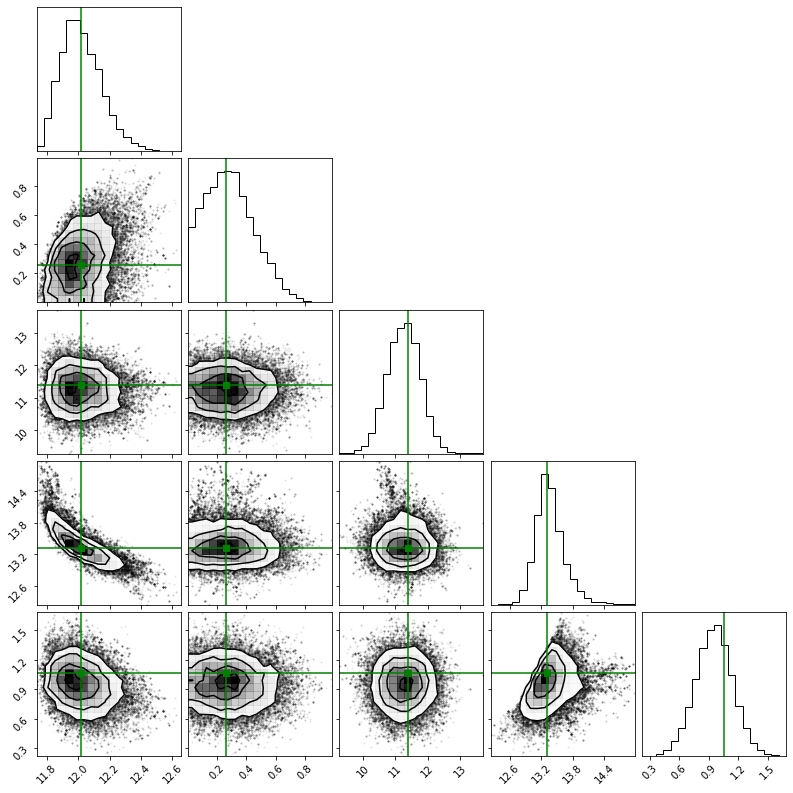

In [52]:
figure = corner.corner(np.array(sampler.chain[:,50:,:]).reshape(-1,5)[:],smoothing=0.00);
value1 = [12.02, 0.26, 11.38, 13.31, 1.06] #true values
ndim = 5
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")
        ax.plot(value1[xi], value1[yi], "sg")

In [53]:
np.save("MCMC_Samples_5D_102122",sampler.chain)